In [53]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import tqdm
import pandas as pd
import seaborn as sns

import matplotlib
matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
ROOT_DIR = os.path.abspath("__file__" + "/../../")
sys.path.insert(0, f"{ROOT_DIR}")

In [3]:
spin_j = 6

env_name = f"single vertex spinfoam/j={float(spin_j)}"
batch_size = 16
n_iterations = int(1e5)

vertex = np.load(f"{ROOT_DIR}/data/EPRL_vertices/Python/Dl_20/vertex_j_{float(spin_j)}.npz")
sq_ampl = vertex**2
grid_rewards = sq_ampl / np.sum(sq_ampl)

grid_len = int(2*spin_j + 1)

In [4]:
mcmc_chains = np.load(f"{ROOT_DIR}/data/MCMC/{env_name}/mcmc_chains.npy")
mcmc_masks = np.load(f"{ROOT_DIR}/data/MCMC/{env_name}/acceptance_masks.npy")
gfn_states = np.load(f"{ROOT_DIR}/data/GFN/{env_name}/terminal_states.npy")

In [36]:
def get_distributions_over_time(grid_positions, grid_len, every_n_iterations=100):
    n_iterations, _, grid_dim = grid_positions.shape

    counts = np.zeros(shape=(grid_len, )*grid_dim)
    n_samples = 0
    empirical_distributions_over_time = []
    n_samples_used_over_time = []
    for i in range(0, n_iterations, every_n_iterations):
        states = np.concatenate(grid_positions[i:i+every_n_iterations])

        n_samples += states.shape[0]
        np.add.at(counts, tuple(states.T), 1)
        
        empirical_distributions_over_time.append(counts/n_samples)
        n_samples_used_over_time.append(n_samples)
    empirical_distributions_over_time = np.stack(empirical_distributions_over_time)
    return empirical_distributions_over_time, n_samples_used_over_time

def get_distributions_over_time_flattened(grid_len, distributions_over_time, iteration = -1):
    distributions_over_time_flattened = []
    grid_coordinates = []
    for i1 in range(grid_len):
        for i2 in range(grid_len):
            for i3 in range(grid_len):
                for i4 in range(grid_len):
                    for i5 in range(grid_len):
                        if len(distributions_over_time.shape) == 6:
                            distributions_over_time_flattened.append(distributions_over_time[iteration, i1, i2, i3, i4, i5])
                        elif len(distributions_over_time.shape) == 5:
                            distributions_over_time_flattened.append(distributions_over_time[i1, i2, i3, i4, i5])
                       
                        grid_coordinates.append(np.array([i1, i2, i3, i4, i5]))

    return grid_coordinates, np.array(distributions_over_time_flattened)

In [37]:
gfn_states = np.load(f"{ROOT_DIR}/data/GFN/single vertex spinfoam/j={float(spin_j)}/terminal_states.npy")

gfn_distributions_over_time, gfn_n_t = get_distributions_over_time(
    gfn_states, grid_len, every_n_iterations=100
)

In [38]:
mcmc_chains = np.load(f"{ROOT_DIR}/data/MCMC/single vertex spinfoam/j={float(spin_j)}/mcmc_chains.npy")
mcmc_distributions_over_time, mcmc_n_t = get_distributions_over_time(
    mcmc_chains, grid_len, every_n_iterations=100, 
)

In [39]:
# Create a 2D array of the grid coordinates and the respective rewards, flattened.
grid_coordinates_list, gfn_distributions_over_time_flattened = get_distributions_over_time_flattened(grid_len, gfn_distributions_over_time)

grid_coordinates_list, mcmc_distributions_over_time_flattened = get_distributions_over_time_flattened(grid_len, mcmc_distributions_over_time)

_, theoretical_distributions_over_time_flattened = get_distributions_over_time_flattened(grid_len, grid_rewards)

In [42]:
df = pd.DataFrame(
    {
        "Coordinates": grid_coordinates_list,
        "Theoretical": theoretical_distributions_over_time_flattened,
        "MCMC": mcmc_distributions_over_time_flattened,
        "GFN": gfn_distributions_over_time_flattened
     }
)

In [43]:
df["distance"] = df["Coordinates"].apply(lambda x: np.sqrt(sum(x**2)))

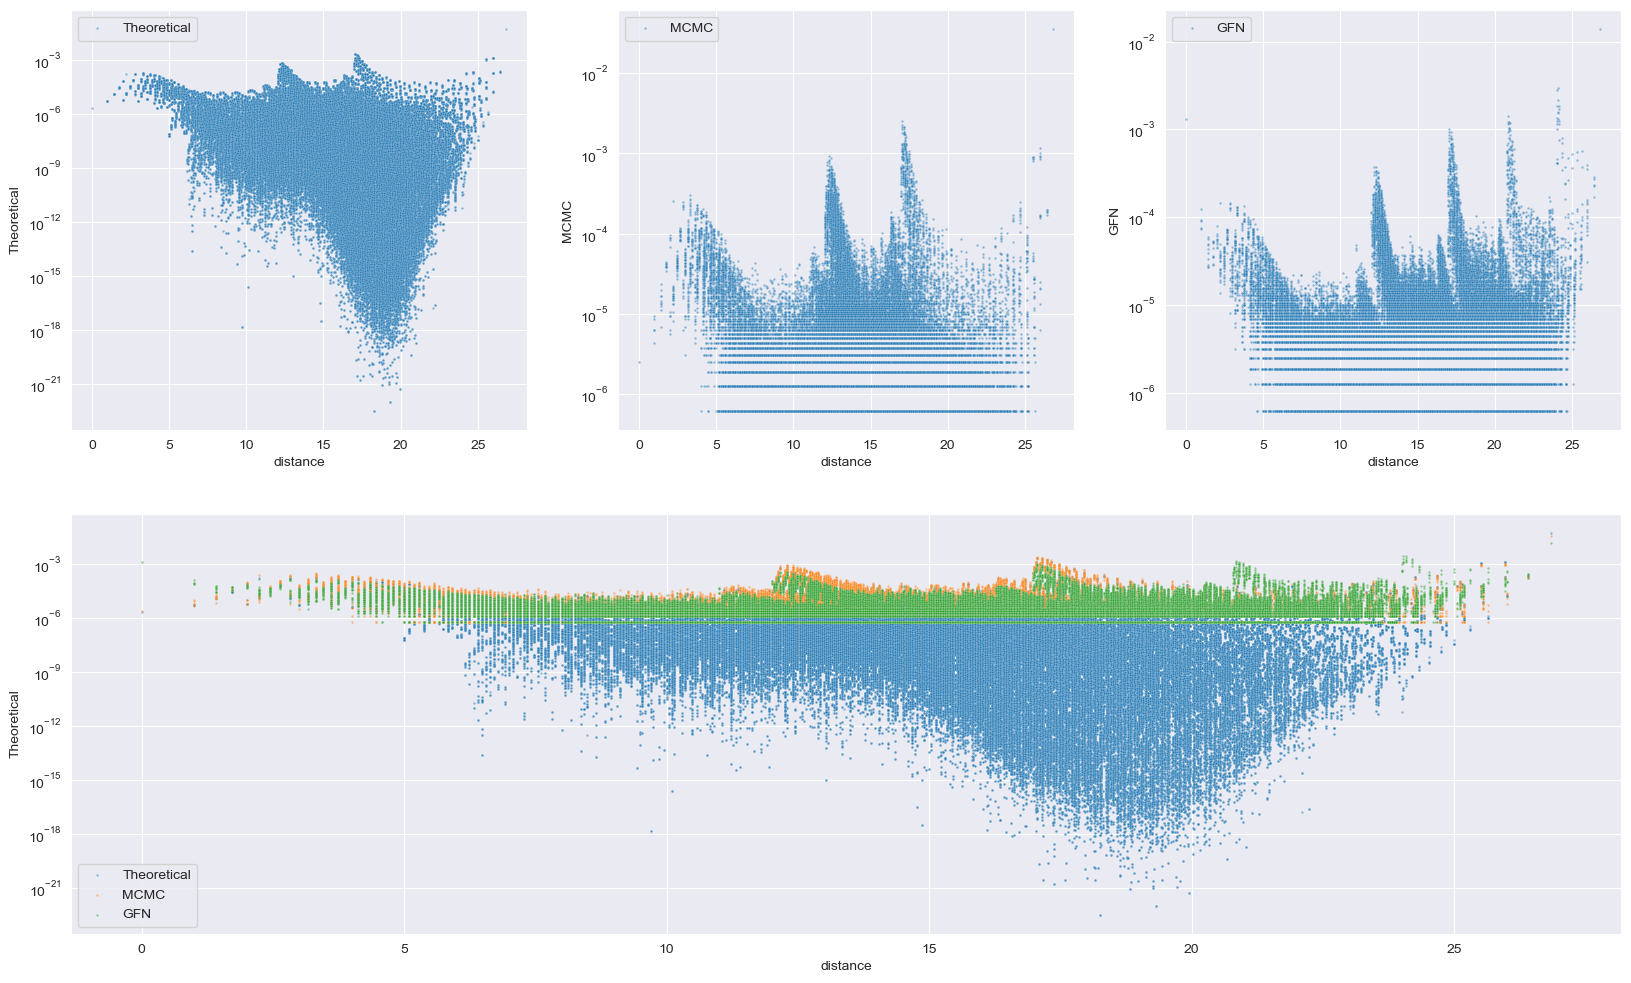

In [68]:
s = 3
alpha = 0.5


sns.set_style("darkgrid")
fig = plt.figure(figsize=(20, 12))

gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, :])

ax1.set_yscale("log")
ax2.set_yscale("log")
ax3.set_yscale("log")
ax4.set_yscale("log")

sns.scatterplot(x=df["distance"], y=df["Theoretical"], label="Theoretical", s=s, alpha=alpha, ax=ax1)
sns.scatterplot(x=df["distance"], y=df["MCMC"], label="MCMC", s=s, alpha=alpha, ax=ax2)
sns.scatterplot(x=df["distance"], y=df["GFN"], label="GFN", s=s, alpha=alpha, ax=ax3)

sns.scatterplot(x=df["distance"], y=df["Theoretical"], label="Theoretical", s=s, alpha=alpha, ax=ax4)
sns.scatterplot(x=df["distance"], y=df["MCMC"], label="MCMC", s=s, alpha=alpha, ax=ax4)
sns.scatterplot(x=df["distance"], y=df["GFN"], label="GFN", s=s, alpha=alpha, ax=ax4)

plt.show()